In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pprint import pprint

import sys
sys.path.append('../')

from plot import ResultPlots

In [2]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()


In [3]:
# Set style
sns.set(style='ticks')

## Disentangling model

In [4]:
models = {
    'without dcor': 0,
    'with dcor': 2
}

In [5]:
with open('model_ids.json') as f:
    model_ids = json.load(f)

In [6]:
# Print hyperparams
for model_name, model_id in models.items():
    print(model_name)
    pprint(model_ids[str(model_id)])
    print('')

without dcor
{'batch_size': 256,
 'checkpoint': None,
 'comment': None,
 'dataset_name': 'zalando_germany',
 'dcor_loss_factor': 0,
 'embeddings_name': 'vits14',
 'grl_weight': None,
 'hidden_dims_branches': [128, 128, 32],
 'hidden_dims_common': [256, 256],
 'input_dim': 384,
 'lr': 0.001,
 'max_epochs': 100,
 'prediction_loss_factor': 1,
 'seed': 4243}

with dcor
{'batch_size': 256,
 'checkpoint': None,
 'comment': None,
 'dataset_name': 'zalando_germany',
 'dcor_loss_factor': 9.670528789445637,
 'embeddings_name': 'vitb14',
 'grl_weight': None,
 'hidden_dims_branches': [256, 256, 256],
 'hidden_dims_common': [256, 256],
 'input_dim': 768,
 'lr': 0.001,
 'max_epochs': 100,
 'prediction_loss_factor': 1,
 'seed': 33}



### Chance level improvement

In [7]:
remove_tasks = ['Shape']

In [8]:
def plot_heatmap(model_id: int, model_name: str, improvement_method: str, cmap: str = 'Blues'):

    # Plotting class instance
    result_plots = ResultPlots(model_id=model_id, parent_dir=f'{DATA_PATH}/Models/disentangled_representations/')

    # Get best metrics
    best_metrics_df = (
        result_plots
        ._get_best_metrics_df()
        .query('~`Feature task`.isin(@remove_tasks) & ~`Target task`.isin(@remove_tasks)')
    )
    metric = result_plots.validation_metrics['metric']

    # Compute improvement
    if improvement_method == 'factor':
        best_metrics_df['improvement'] = (best_metrics_df.best / best_metrics_df.baseline) - 1
    elif improvement_method == 'difference':
        best_metrics_df['improvement'] = best_metrics_df.best - best_metrics_df.baseline
    else:
        raise ValueError(f"Unknown improvement method: {improvement_method}")

    # Pivot
    improvement_df = best_metrics_df.pivot(index='Target task', columns='Feature task', values='improvement')
    improvement_df = improvement_df.clip(lower=0)

    # Remove 'task' from index and column level names
    improvement_df = improvement_df.rename_axis(
        index=improvement_df.index.name.replace('task', ''),
        columns=improvement_df.columns.name.replace('task', '')
    )

    # Create the heatmap
    ax = sns.heatmap(
        improvement_df,
        square=True,
        annot=True, fmt=".2f", annot_kws={'size': 10},
        cmap=cmap,
        vmin=0, vmax=17 if improvement_method == 'factor' else 0.45,
        linewidths=0.5
    )

    # Set title of colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_label(f'{metric.title()} improvement ({improvement_method} to chance level)')

    ax.set_title(model_name.capitalize(), fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', verticalalignment='center_baseline')

    # Save plot
    #plt.savefig(f'{metric}_improvement_{improvement_method}_to_chance_level_{model_name}.svg', bbox_inches='tight')

    plt.show()

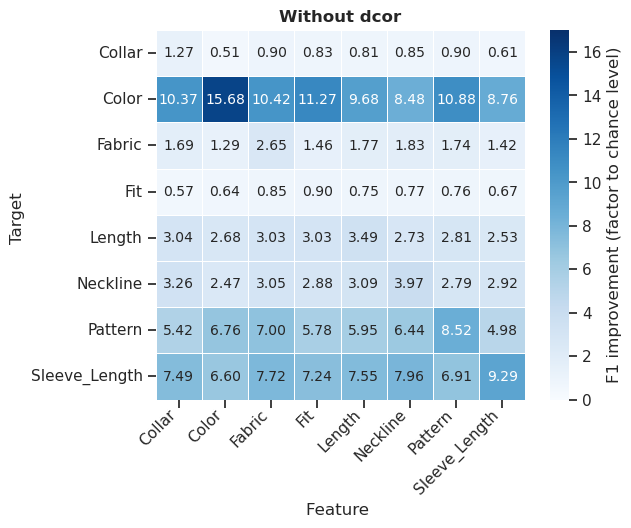

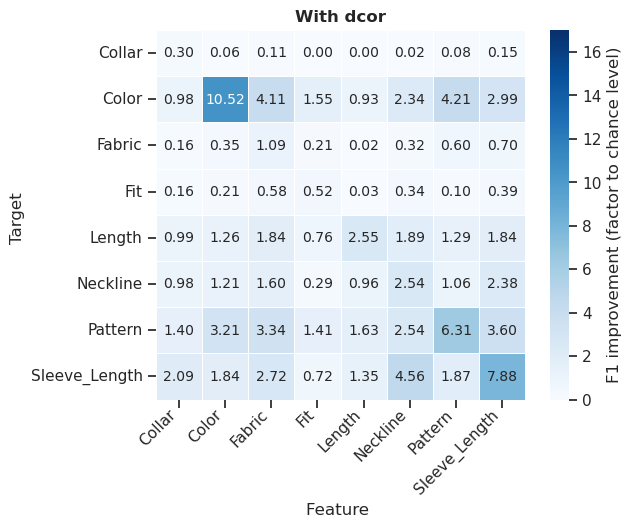

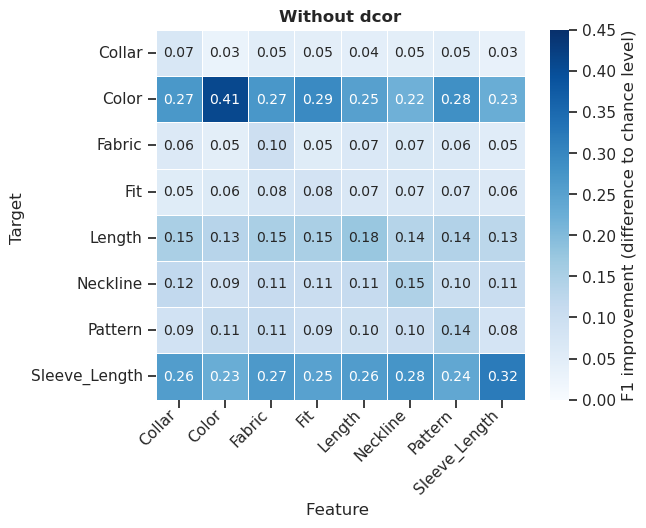

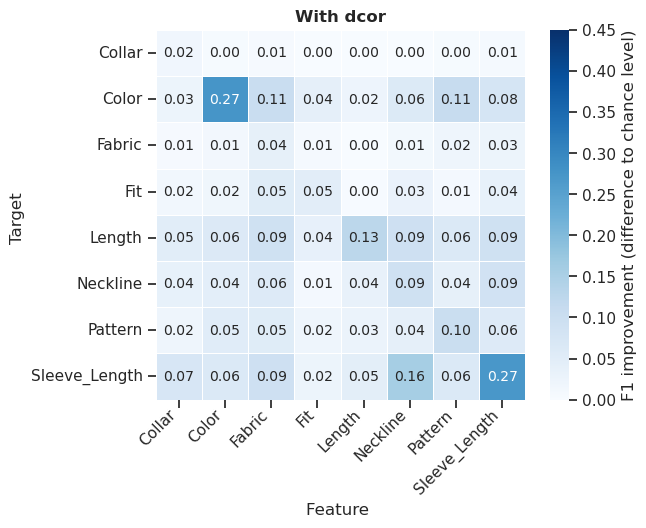

In [9]:
for improvement_method in ['factor', 'difference']:
    for model_name, model_id in models.items():
        plot_heatmap(model_id, model_name, improvement_method, cmap='Blues')

### Distance correlation

In [10]:
def get_loss(result_plots, losstype='dcor', **kwargs):
    """Get distance correlation losses for the best epoch of the model."""
    losses = []

    # Get best epoch
    best_epoch_by = 'loss'
    best_epoch = result_plots.results[best_epoch_by]['best_epoch']

    for sample in ['train', 'validation']:
        losstype_idx = ['dcor', 'prediction'].index(losstype)
        loss = result_plots.results['loss_drilldown'][sample][best_epoch][losstype_idx]
        losses.append({
            'sample': sample,
            f'{losstype}_loss': loss[np.tril_indices_from(loss, k=-1)].mean(),
            **kwargs
        })

    return losses

#### Simple comparison: best vs no-docr model

In [11]:
dcor_losses = []
for model_name, model_id in models.items():
    result_plots = ResultPlots(model_id=model_id, parent_dir=f'{DATA_PATH}/Models/disentangled_representations/')
    dcor_losses += get_loss(result_plots, losstype='dcor', model=model_name)
dcor_losses_df = pd.DataFrame(dcor_losses).rename(columns={'loss': 'dcor'})

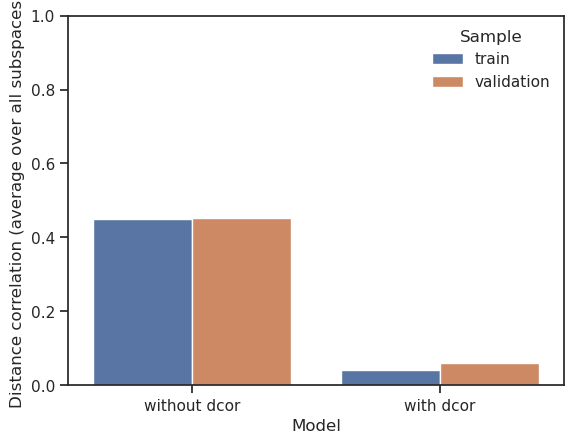

In [12]:
sns.barplot(x='model', y='dcor_loss', hue='sample', data=dcor_losses_df)
plt.ylim(0, 1)
plt.xlabel('Model')
plt.ylabel('Distance correlation (average over all subspaces)')
plt.legend(title='Sample', frameon=False)
#plt.savefig('distance_correlation_losses.svg', bbox_inches='tight')
plt.show()